In [12]:
%store -r core_area core_meanlon core_meanlat df_lifetime df

In [13]:
# Import libraries

import numpy as np
import rasterio
import pandas as pd
from scipy.spatial import cKDTree
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [14]:
# Extract longitudes and latitudes for each class 

# Open the geotiff file
with rasterio.open("../data/rasters/residential.tif") as src:
    # Read the image data into a 2D numpy array
    image = src.read(1)
    # Get the transformation matrix of the image
    transform = src.transform

# Create a dictionary to store the coordinates for each class
coordinates_by_class = {}

# For each unique value in the image (which represents a class)
for class_value in np.unique(image):
    # If the value is not 0 (0 typically represents no data)
    if class_value != 0:
        # Get the indices of the pixels that belong to this class
        indices = np.where(image == class_value)
        # Convert the indices to coordinates
        coordinates = [transform * (x, y) for x, y in zip(*indices)]
        # Store the coordinates in the dictionary
        coordinates_by_class[class_value] = coordinates

# Now `coordinates_by_class` is a dictionary where the keys are the classes and the values
# are lists of (longitude, latitude) tuples for each pixel in that class.



In [15]:
core_area_pd = pd.read_csv('../data/core_area_1.csv')

# Assuming you have the 'coordinates_by_class' and 'core_area_pd' as provided in your code

# Create KDTree for df_core_areas to perform nearest-neighbor search
df_core_areas = core_area_pd[['Longitude', 'Latitude', 'core_area']]
tree = cKDTree(df_core_areas[['Longitude', 'Latitude']].values)

# Loop over the keys (classes) in coordinates_by_class
for class_num in range(1, 5):
    # Create Pandas DataFrame for the current class
    df_coords = pd.DataFrame(coordinates_by_class[class_num], columns=['Longitude', 'Latitude'])
    
    # Find the index of the nearest neighbor in df_core_areas for each point in df_coords
    _, idx = tree.query(df_coords[['Longitude', 'Latitude']].values)
    
    # Merge based on the nearest-neighbor index
    merged_df = df_coords.join(df_core_areas.iloc[idx][['core_area']].reset_index(drop=True))
    
    # Save the result DataFrame to a CSV file
    merged_df.to_csv(f'../data/LCZ_classes/class{class_num}.csv', index=False)


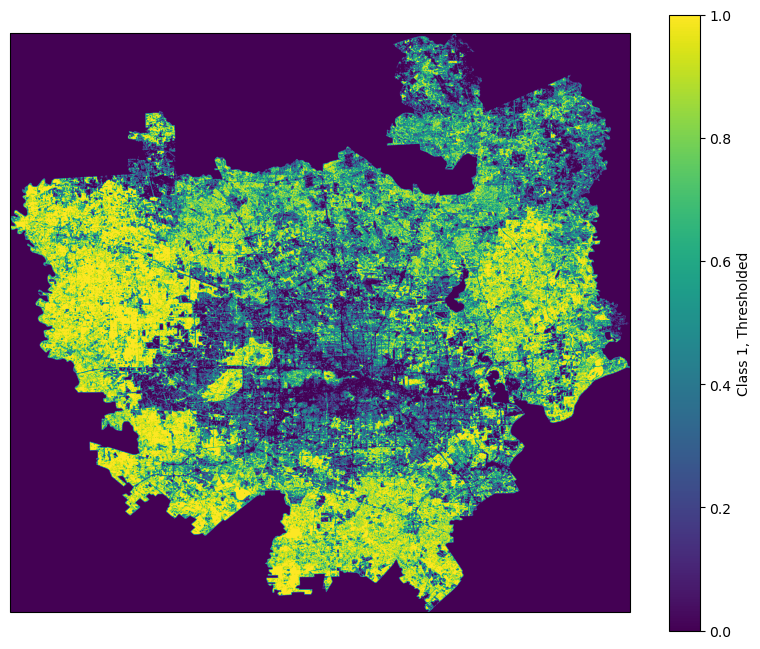

In [16]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import rasterio
import numpy as np

# Step 1: Load the GeoTIFF raster file
raster = rasterio.open('../data/combined_classification.tif')

# Step 2: Extract only the data for Class 1
data = raster.read(1)  # Read the first (and only) band
class_1_mask = data == 4  # Create a mask for Class 1

# Apply the threshold: Values less than 0.99 are 0, values greater or equal to 0.99 are 1
thresholded_mask = np.where(class_1_mask & (data >= 0.99), 1, 0)

# Step 3: Create a geographical plot using Cartopy
crs = ccrs.PlateCarree()  # Use Plate Carree (latitude/longitude) projection
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': crs})

# Get the extent of the raster
xmin = raster.transform[2]
ymin = raster.transform[5]
xmax = xmin + raster.transform[0]*raster.width
ymax = ymin + raster.transform[4]*raster.height

# Plot the thresholded mask for Class 1
img = ax.imshow(thresholded_mask, origin='upper', extent=[xmin, xmax, ymin, ymax], transform=crs, cmap='viridis')

# Add a color bar
plt.colorbar(img, ax=ax, orientation='vertical', label='Class 1, Thresholded')

plt.show()


# Spatial variation of core area for each LCZ class

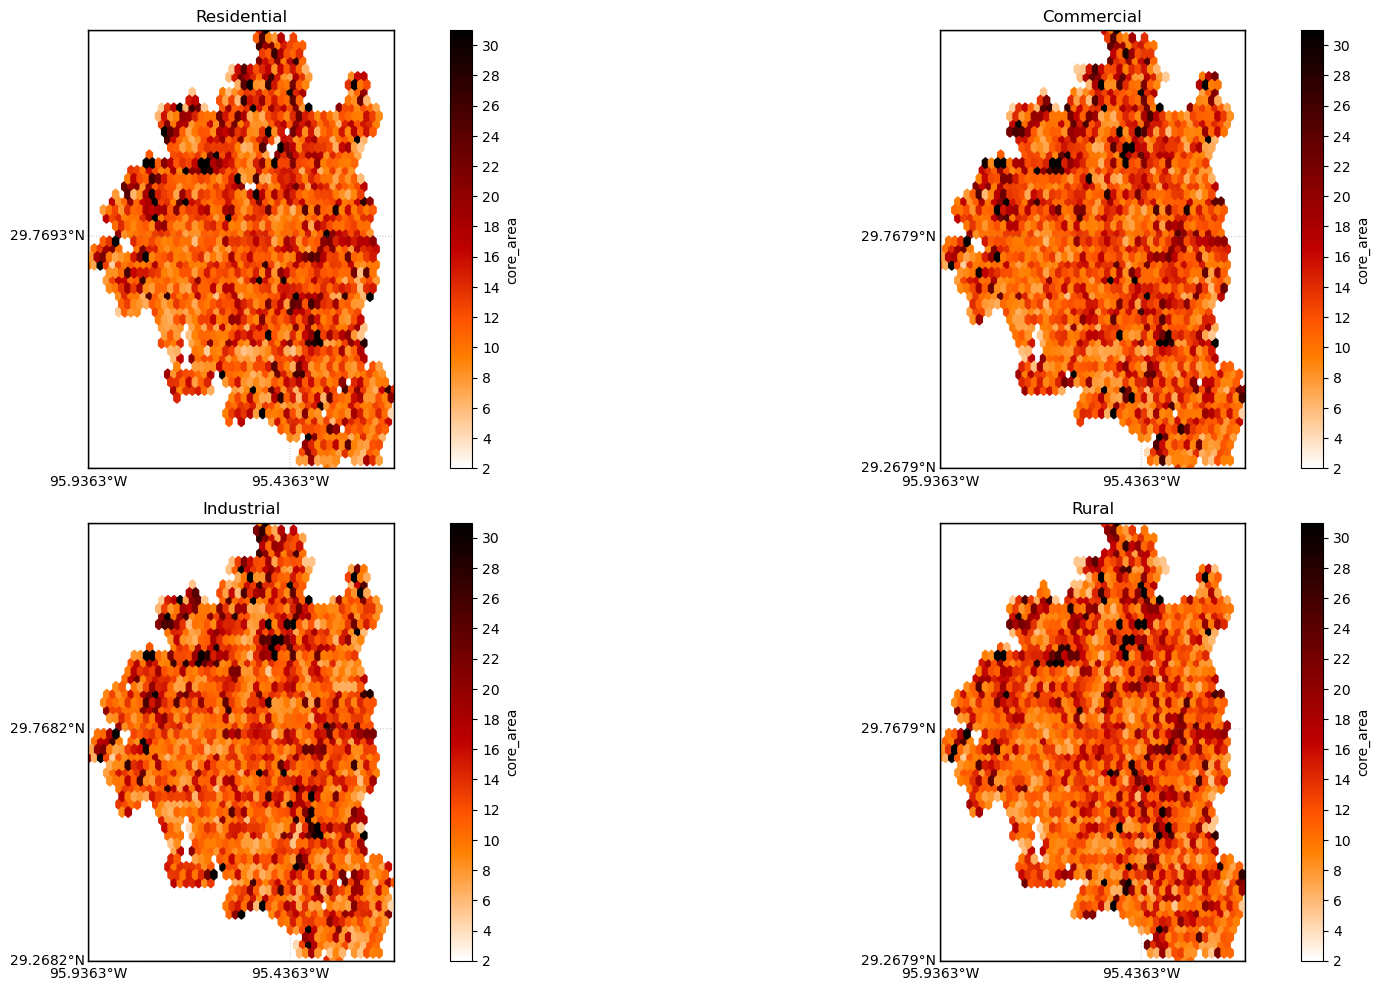

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
from scipy.interpolate import griddata
import pandas as pd

# Define the grid over which we'll interpolate
grid_resolution = 0.1

# Global minimum and maximum 'core_area'
global_min = 2
global_max = 31

# Define colorbar ticks
ticks = np.arange(global_min, global_max + 1, 2)

# Define class names
class_names = ["Residential", "Commercial", "Industrial", "Rural"]

# Create a new figure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))  # 2 rows, 2 columns
axes = axes.flatten()

# Iterate over class numbers, names
for class_num, class_name in zip(range(1, 5), class_names):
    # Load the data
    data = pd.read_csv(f'../data/LCZ_classes/class{class_num}.csv')

    grid_lons = np.arange(min(data['Longitude']), max(data['Longitude']), grid_resolution)
    grid_lats = np.arange(min(data['Latitude']), max(data['Latitude']), grid_resolution)
    grid_lons, grid_lats = np.meshgrid(grid_lons, grid_lats)

    # Interpolate the data using cubic interpolation
    var_interp = griddata((data['Longitude'], data['Latitude']), data['core_area'], 
                          (grid_lons, grid_lats), method='cubic')

    # Set up the basemap
    m = Basemap(projection='merc', llcrnrlat=data['Latitude'].min(), urcrnrlat=data['Latitude'].max(), 
                llcrnrlon=data['Longitude'].min(), urcrnrlon=data['Longitude'].max(), resolution='i', ax=axes[class_num - 1])

    # Convert longitudes and latitudes to map projection coordinates
    x, y = m(data['Longitude'].values, data['Latitude'].values)

    # Create a hexbin plot (2D histogram) of the data
    hb = m.hexbin(x, y, C=data['core_area'].values, gridsize=50, cmap='gist_heat_r', mincnt=1, reduce_C_function=np.mean, vmin=global_min, vmax=global_max)

    # Draw map details
    m.drawmapboundary()
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()

    # Add a colorbar with specific tick locations
    cb = fig.colorbar(hb, ax=axes[class_num - 1], pad=0.05, ticks=ticks)
    cb.set_label('core_area')

    # Add labels
    parallels = m.drawparallels(np.arange(data['Latitude'].min(), data['Latitude'].max(), 0.5), labels=[1, 0, 0, 0], color='gray', dashes=[1, 3], linewidth=0.5)
    meridians = m.drawmeridians(np.arange(data['Longitude'].min(), data['Longitude'].max(), 0.5), labels=[0, 0, 0, 1], color='gray', dashes=[1, 3], linewidth=0.5)
    axes[class_num - 1].set_title(class_name)

# Display the plot
plt.tight_layout()
plt.show()


In [24]:
data['Longitude'].min()

-95.93629319299998

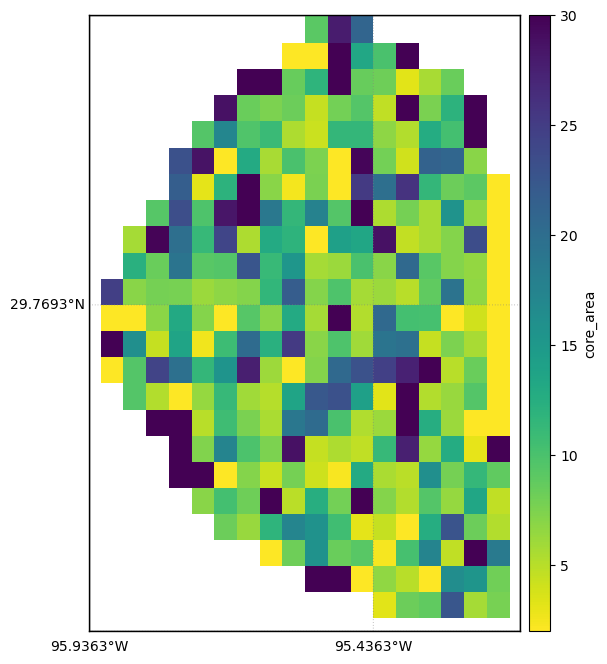

In [18]:
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Load the data
data = pd.read_csv('../data/LCZ_classes/class1.csv')

# Define the grid over which we'll interpolate
grid_resolution = 0.04  # Decrease this to increase the number of bins
grid_lons = np.arange(min(data['Longitude']), max(data['Longitude']), grid_resolution)
grid_lats = np.arange(min(data['Latitude']), max(data['Latitude']), grid_resolution)
grid_lons, grid_lats = np.meshgrid(grid_lons, grid_lats)

# Interpolate the data using cubic interpolation
var_interp = griddata((data['Longitude'], data['Latitude']), data['core_area'], 
                      (grid_lons, grid_lats), method='cubic')

# Create a new figure
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

# Set up the basemap
m = Basemap(projection='merc', llcrnrlat=data['Latitude'].min(), urcrnrlat=data['Latitude'].max(), 
            llcrnrlon=data['Longitude'].min(), urcrnrlon=data['Longitude'].max(), resolution='l')

# Convert longitudes and latitudes to map projection coordinates
x, y = m(grid_lons, grid_lats)

# Create a masked array for the interpolated data
masked_interp = np.ma.array(var_interp, mask=np.isnan(var_interp))

# Plot the interpolated data
im = m.pcolormesh(x, y, masked_interp, cmap='viridis_r', shading='auto', vmin=2, vmax=30)

# Draw map details
m.drawmapboundary()
m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Add a colorbar
cbar = m.colorbar(im, location='right', pad='2%')
cbar.set_label('core_area')

# Add labels
parallels = m.drawparallels(np.arange(data['Latitude'].min(), data['Latitude'].max(), 0.5), labels=[1, 0, 0, 0], 
                             color='gray', dashes=[1, 3], linewidth=0.5)
meridians = m.drawmeridians(np.arange(data['Longitude'].min(), data['Longitude'].max(), 0.5), labels=[0, 0, 0, 1], 
                            color='gray', dashes=[1, 3], linewidth=0.5)

# Display the plot
plt.show()


# Spatial variation of precipitation for each LCZ class

In [19]:
# Subset only the non-zero precip values and concatenate them

import pandas as pd

# Read the three precipitation files
file1 = pd.read_csv('../total_precip_summer_first.csv')
file2 = pd.read_csv('../total_precip_summer_second.csv')
file3 = pd.read_csv('../total_precip_summer_third.csv')

# Subset only the non-zero precipitation values
file1_nonzero = file1[file1['Precipitation'] != 0]
file2_nonzero = file2[file2['Precipitation'] != 0]
file3_nonzero = file3[file3['Precipitation'] != 0]

# Concatenate the non-zero precipitation values vertically
#concatenated_data = pd.concat([file1_nonzero, file2_nonzero, file3_nonzero])
concatenated_data = pd.concat([file1, file2, file3])

# Select only the desired columns
final_output = concatenated_data[['Longitude', 'Latitude', 'Precipitation']]

# Print the final output
#final_output.to_csv('./data/final_output_1.csv', index=False)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
core_area_pd = final_output

# Assuming you have the 'coordinates_by_class' and 'core_area_pd' as provided in your code

# Create KDTree for df_core_areas to perform nearest-neighbor search
df_core_areas = core_area_pd[['Longitude', 'Latitude', 'Precipitation']]
tree = cKDTree(df_core_areas[['Longitude', 'Latitude']].values)

# Loop over the keys (classes) in coordinates_by_class
for class_num in range(1, 17):
    # Create Pandas DataFrame for the current class
    df_coords = pd.DataFrame(coordinates_by_class[class_num], columns=['Longitude', 'Latitude'])
    
    # Find the index of the nearest neighbor in df_core_areas for each point in df_coords
    _, idx = tree.query(df_coords[['Longitude', 'Latitude']].values)
    
    # Merge based on the nearest-neighbor index
    merged_df_precip = df_coords.join(df_core_areas.iloc[idx][['Precipitation']].reset_index(drop=True))
    
    # Save the result DataFrame to a CSV file
    merged_df_precip.to_csv(f'../data/precip/class{class_num}.csv', index=False)


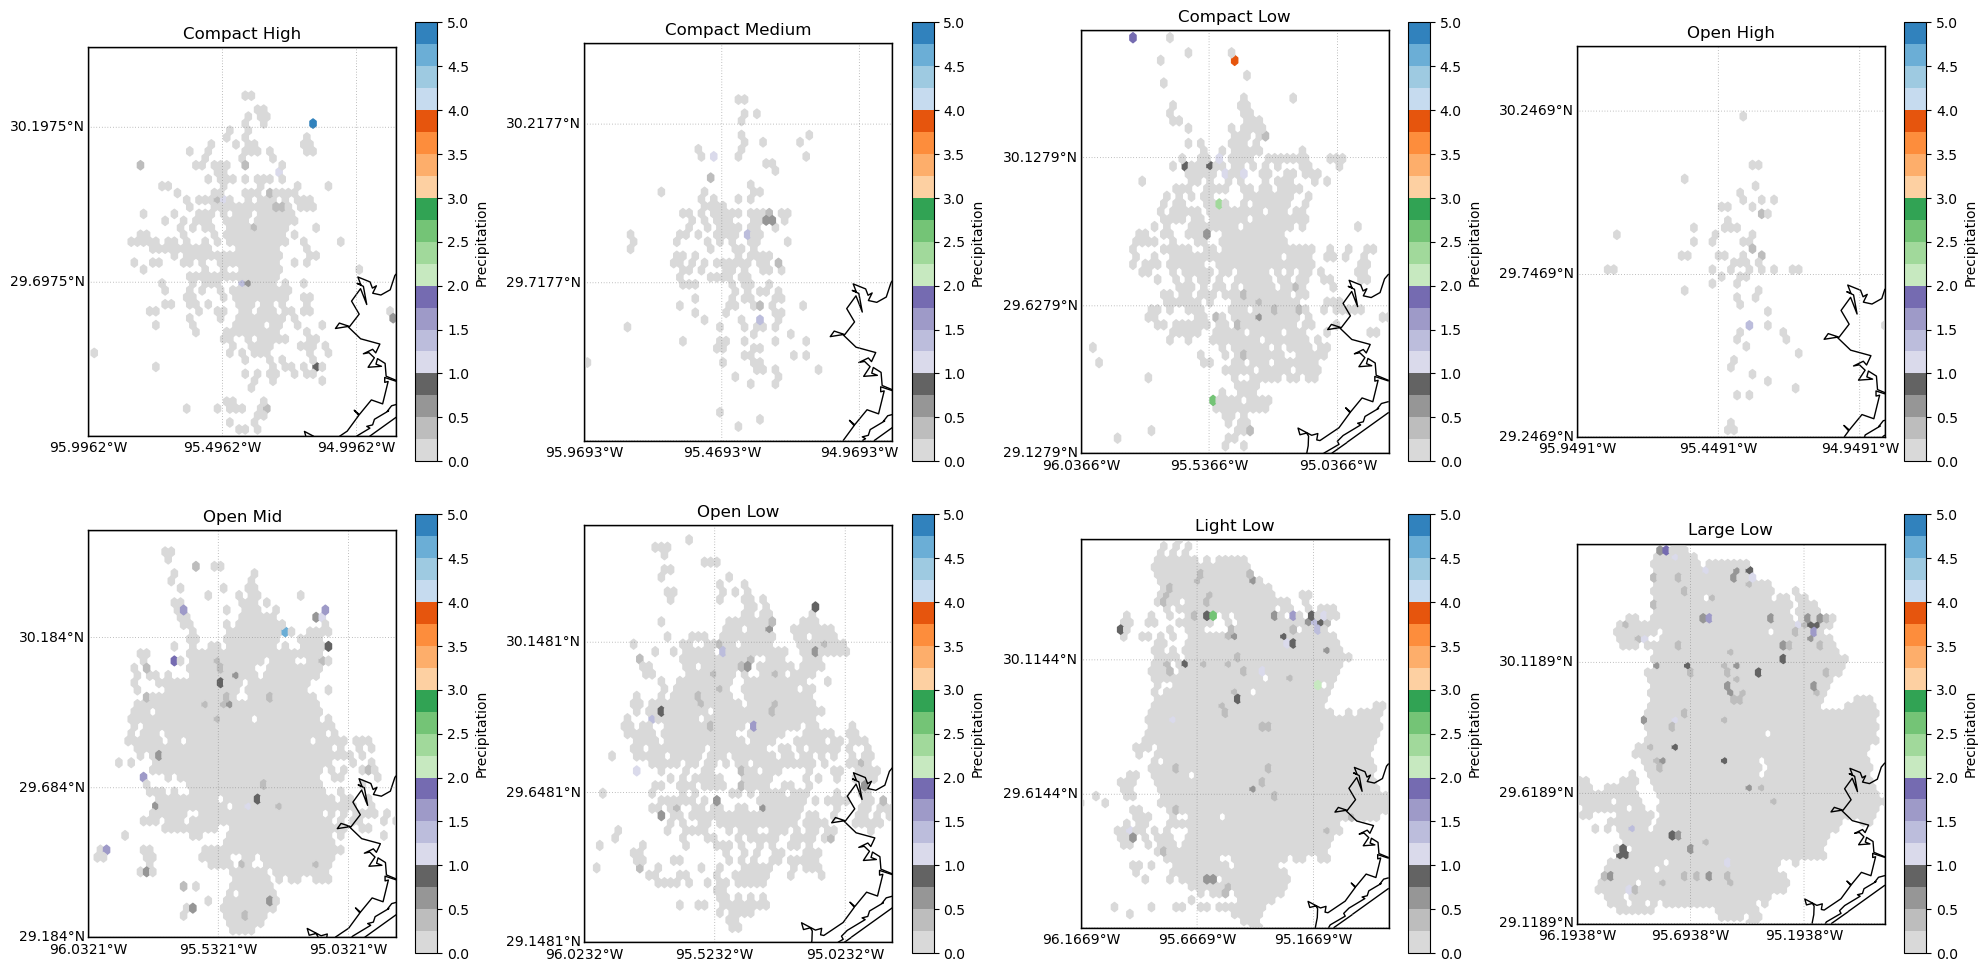

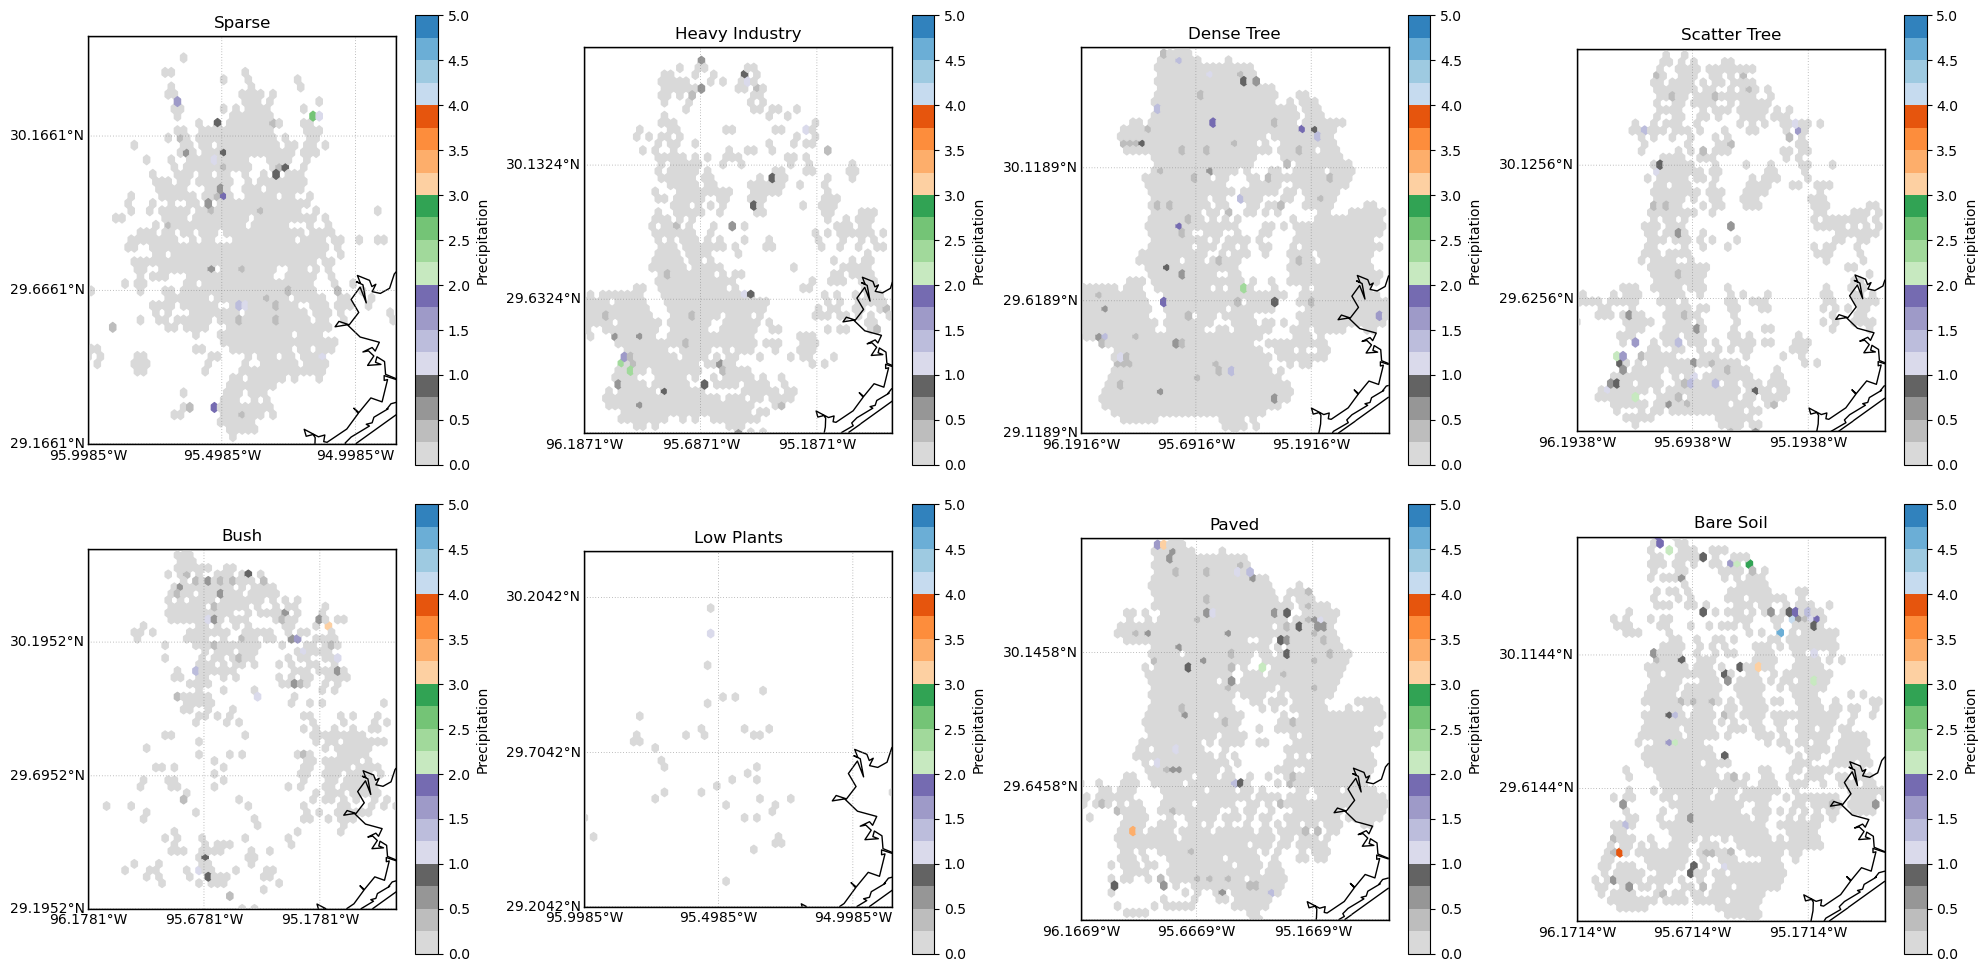

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
from scipy.interpolate import griddata
import pandas as pd

# Define the grid over which we'll interpolate
grid_resolution = 0.1

# Find global minimum and maximum 'core_area' across all datasets
global_min = 0  # min(pd.read_csv(f'../data/LCZ_classes/class{i}.csv')['core_area'].min() for i in range(1, 17))
global_max = 5  # max(pd.read_csv(f'../data/LCZ_classes/class{i}.csv')['core_area'].max() for i in range(1, 17))

# Define colorbar ticks
ticks = np.arange(global_min, global_max + 0.5, 0.5)  # ticks from global_min to global_max with a step of 0.5

# Define class names
class_names = ["Compact High", "Compact Medium", "Compact Low", "Open High", "Open Mid", "Open Low", "Light Low", "Large Low",
               "Sparse", "Heavy Industry", "Dense Tree", "Scatter Tree", "Bush", "Low Plants", "Paved", "Bare Soil", "water"]

# Iterate over class numbers, names
for class_num, class_name in zip(range(1, 17), class_names):
    # Determine the figure (1 or 2) and the subplot index within that figure
    fig_num = 1 if class_num <= 8 else 2
    subplot_index = (class_num - 1) % 8

    # Create a new figure if necessary
    if subplot_index == 0:
        fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))  # 2 rows, 4 columns per figure
        axes = axes.flatten()

    # Load the data
    data = pd.read_csv(f'../data/precip/class{class_num}.csv')

    grid_lons = np.arange(min(data['Longitude']), max(data['Longitude']), grid_resolution)
    grid_lats = np.arange(min(data['Latitude']), max(data['Latitude']), grid_resolution)
    grid_lons, grid_lats = np.meshgrid(grid_lons, grid_lats)

    # Interpolate the data using cubic interpolation
    var_interp = griddata((data['Longitude'], data['Latitude']), data['Precipitation'], 
                          (grid_lons, grid_lats), method='cubic')

    # Set up the basemap
    m = Basemap(projection='merc', llcrnrlat=data['Latitude'].min(), urcrnrlat=data['Latitude'].max(), 
                llcrnrlon=data['Longitude'].min(), urcrnrlon=data['Longitude'].max(), resolution='i', ax=axes[subplot_index])

    # Convert longitudes and latitudes to map projection coordinates
    x, y = m(data['Longitude'].values, data['Latitude'].values)

    # Create a hexbin plot (2D histogram) of the data
    hb = m.hexbin(x, y, C=data['Precipitation'].values, gridsize=50, cmap='tab20c_r', mincnt=1, reduce_C_function=np.mean, vmin=global_min, vmax=global_max)

    # Draw map details
    m.drawmapboundary()
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()

    # Add a colorbar with specific tick locations
    cb = fig.colorbar(hb, ax=axes[subplot_index], pad=0.05, ticks=ticks)
    cb.set_label('Precipitation')

    # Add labels
    parallels = m.drawparallels(np.arange(data['Latitude'].min(), data['Latitude'].max(), 0.5), labels=[1, 0, 0, 0], 
                                 color='gray', dashes=[1, 3], linewidth=0.5)
    meridians = m.drawmeridians(np.arange(data['Longitude'].min(), data['Longitude'].max(), 0.5), labels=[0, 0, 0, 1], 
                                color='gray', dashes=[1, 3], linewidth=0.5)
    axes[subplot_index].set_title(class_name)  # use the class name instead of the class number

    # Display the plot and start a new one if necessary
    if subplot_index == 7:
        plt.tight_layout()
        plt.show()

# Show the second figure if it has less than 8 subplots
if subplot_index != 7:
    plt.tight_layout()
    plt.show()


# Variation of core area/cell area across lifetime for each LCZ

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.merge(df, merged_df, on='core_area')

# Calculate quartiles for cell_area
df['cell_area_quartiles'] = pd.qcut(df['cell_area'], 4, labels=['Very Small Cells', 'Small Cells', 'Large Cells', 'Very Large Cells'])

In [ ]:
# Define lifetime bins
bins = [0, 1, 2, 3, 4, 5, 6]

# Categorize lifetime into bins
df['lifetime_bin'] = pd.cut(df['lifetime'], bins=bins, include_lowest=True)

# Calculate the mean core_area for each lifetime bin and cell_area quartile
df_grouped = df.groupby(['cell_area_quartiles', 'lifetime_bin'])['core_area'].mean().reset_index()

# Convert lifetime_bin to its mid-points
df_grouped['lifetime_mid'] = df_grouped['lifetime_bin'].apply(lambda x: x.mid)

In [ ]:
# Initialize a MinMaxScaler
scaler = MinMaxScaler()

# Normalize core_area within each cell_area quartile
df_grouped['core_area_normalized'] = df_grouped.groupby('cell_area_quartiles')['core_area'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).ravel())

# Create a custom color palette
palette = {'Very Small Cells': 'blue', 'Small Cells': 'green', 'Large Cells': 'orange', 'Very Large Cells': 'red'}

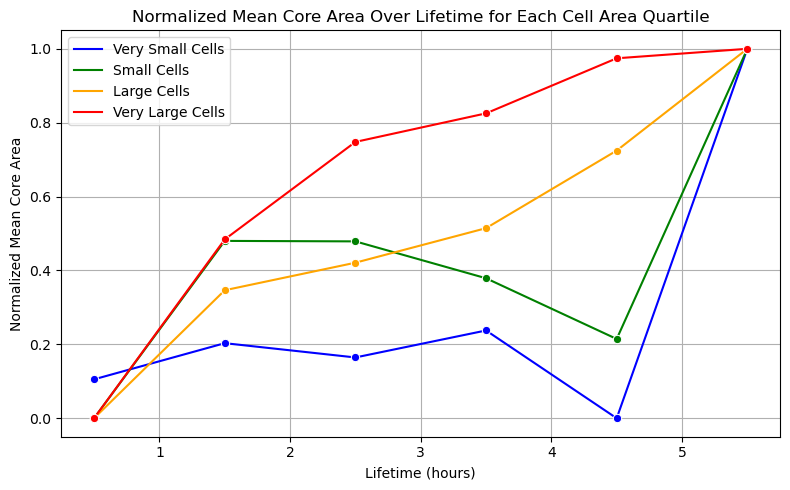

In [ ]:
# Create a figure
fig, ax = plt.subplots(figsize=(8, 5))

'''
# This is the code for the first subplot
# ax0 = sns.lineplot(ax=axes[0], data=df_grouped, x='lifetime_mid', y='core_area', hue='cell_area_quartiles', palette=palette, marker='o')
# ax0.set_title('Non-normalized Mean Core Area Over Lifetime for Each Cell Area Quartile')
# ax0.set_xlabel('Lifetime (hours)')
# ax0.set_ylabel('Mean Core Area (km^2)')
# ax0.grid(True)
# ax0.legend(title='')
'''

# Plot the normalized data
sns.lineplot(ax=ax, data=df_grouped, x='lifetime_mid', y='core_area_normalized', hue='cell_area_quartiles', palette=palette, marker='o')
ax.set_title('Normalized Mean Core Area Over Lifetime for Each Cell Area Quartile')
ax.set_xlabel('Lifetime (hours)')
ax.set_ylabel('Normalized Mean Core Area')
ax.grid(True)
ax.legend(title='')

# Adjust the layout
plt.tight_layout()
plt.show()
